# GPyTorch starter code
https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html

Issue: requires full batch training...

In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
noise = torch.randn(train_x.size()) * math.sqrt(0.04)
signal = torch.sin(train_x * (2 * math.pi))
train_y = signal + noise

noise_var = (signal - noise)**2
# noise_var = torch.ones_like(train_y) * 0.04

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise_var)  # Add noise term

model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.mean()
    ))
    optimizer.step()

Iter 1/100 - Loss: 3.045   lengthscale: 0.693   noise: 0.531
Iter 2/100 - Loss: 2.673   lengthscale: 0.644   noise: 0.531
Iter 3/100 - Loss: 2.266   lengthscale: 0.598   noise: 0.531
Iter 4/100 - Loss: 1.868   lengthscale: 0.554   noise: 0.531
Iter 5/100 - Loss: 1.520   lengthscale: 0.513   noise: 0.531
Iter 6/100 - Loss: 1.246   lengthscale: 0.474   noise: 0.531
Iter 7/100 - Loss: 1.046   lengthscale: 0.439   noise: 0.531
Iter 8/100 - Loss: 0.907   lengthscale: 0.407   noise: 0.531
Iter 9/100 - Loss: 0.813   lengthscale: 0.378   noise: 0.531
Iter 10/100 - Loss: 0.750   lengthscale: 0.352   noise: 0.531
Iter 11/100 - Loss: 0.709   lengthscale: 0.330   noise: 0.531
Iter 12/100 - Loss: 0.683   lengthscale: 0.310   noise: 0.531
Iter 13/100 - Loss: 0.666   lengthscale: 0.293   noise: 0.531
Iter 14/100 - Loss: 0.655   lengthscale: 0.278   noise: 0.531
Iter 15/100 - Loss: 0.647   lengthscale: 0.265   noise: 0.531
Iter 16/100 - Loss: 0.641   lengthscale: 0.253   noise: 0.531
Iter 17/100 - Los

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

/home/anjum/anaconda3/envs/kaggle/lib/python3.8/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:225: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


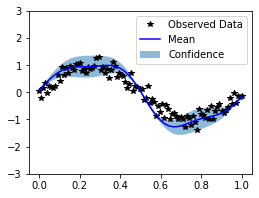

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [7]:
observed_pred.mean

tensor([ 0.0646,  0.2323,  0.3906,  0.5333,  0.6554,  0.7539,  0.8281,  0.8794,
         0.9110,  0.9277,  0.9347,  0.9377,  0.9410,  0.9478,  0.9589,  0.9726,
         0.9848,  0.9895,  0.9789,  0.9451,  0.8808,  0.7806,  0.6421,  0.4665,
         0.2586,  0.0274, -0.2157, -0.4573, -0.6838, -0.8829, -1.0448, -1.1637,
        -1.2376, -1.2692, -1.2644, -1.2320, -1.1819, -1.1238, -1.0660, -1.0140,
        -0.9703, -0.9341, -0.9017, -0.8673, -0.8241, -0.7656, -0.6863, -0.5831,
        -0.4555, -0.3059, -0.1394])